## LSTM Univariate Single-Step Style 

In [57]:
#Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt

#tf.random.set_seed(123)
#np.random.seed(123)

In [58]:
#Leitura dos dados
df = pd.read_csv(r'Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')

In [59]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [60]:
df.drop_duplicates(subset=['date_time'], keep=False, inplace=True)

In [61]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index, inplace=True)

uni_data = df['traffic_volume']

uni_data.index = df['date_time']

In [62]:
uni_data = uni_data.values

scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1,1))

x_rescaled

array([[0.76167582],
       [0.62032967],
       [0.65480769],
       ...,
       [0.39587912],
       [0.50837912],
       [0.55618132]])

In [63]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
    X = []
    y = []

    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start,end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window,1)))
        indicesy = range(i, i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

In [64]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 3000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT, univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None, univar_hist_window, horizon)
print('Single window of past history')
print(x_train_uni[0])
print('\n Target horizon')
print(y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]]


In [65]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

lstm_model = tf.keras.models.Sequential([   tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
                                            tf.keras.layers.Dropout(0.2),
                                            tf.keras.layers.LSTM(units=50, return_sequences=False),
                                            tf.keras.layers.Dropout(0.2),
                                            tf.keras.layers.Dense(units=1)])

lstm_model.compile(optimizer='adam', loss='mse')

In [66]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = lstm_model.fit(   train_univariate,
                            epochs = EPOCHS,
                            steps_per_epoch = EVALUATION_INTERVAL,
                            validation_data = val_univariate,
                            validation_steps = 50,
                            verbose = 1,
                            callbacks = [   tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')])

Epoch 1/150
100/100 [==============================] - 18s 157ms/step - loss: 0.0642 - val_loss: 0.0358
Epoch 2/150
100/100 [==============================] - 16s 163ms/step - loss: 0.0324 - val_loss: 0.0252
Epoch 3/150
100/100 [==============================] - 16s 164ms/step - loss: 0.0250 - val_loss: 0.0179
Epoch 4/150
100/100 [==============================] - 17s 173ms/step - loss: 0.0191 - val_loss: 0.0149
Epoch 5/150
100/100 [==============================] - 17s 170ms/step - loss: 0.0164 - val_loss: 0.0141
Epoch 6/150
100/100 [==============================] - 17s 167ms/step - loss: 0.0161 - val_loss: 0.0143
Epoch 7/150
100/100 [==============================] - 17s 168ms/step - loss: 0.0150 - val_loss: 0.0136
Epoch 8/150
100/100 [==============================] - 17s 171ms/step - loss: 0.0148 - val_loss: 0.0134
Epoch 9/150
100/100 [==============================] - 17s 169ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 10/150
100/100 [==============================] - 16s 163m

In [67]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 48, 100)           40800     
                                                                 
 dropout_8 (Dropout)         (None, 48, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


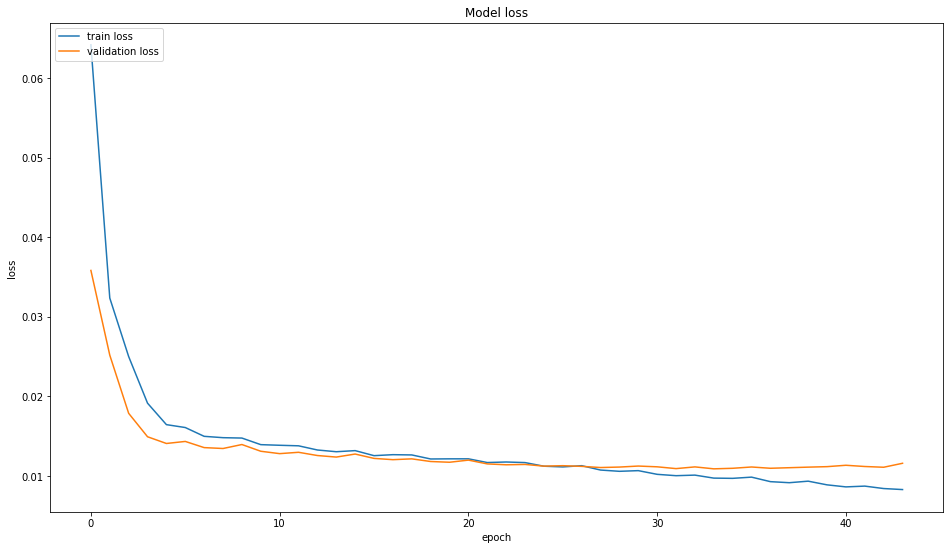

In [68]:
#Plot the loss and val_loss against the epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc = 'upper left')
plt.rcParams['figure.figsize'] = [16,9]
plt.show()

In [69]:
uni = df['traffic_volume']
validatehorizonte = uni.tail(48)
validatehistory = validatehorizonte.values
result = []

#Definição do tamanho do forecast

window_len = 10

val_rescaled = scaler_x.fit_transform(validatehistory.reshape(-1,1))

for i in range(1, window_len + 1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0],1))
    Predicted_results = lstm_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(   val_rescaled[:,1:],
                                [[Predicted_results]])
    print(val_rescaled) 


predicted : [[0.63488245]]
[0.80830343 0.77960021 0.83000171 0.94020161 1.         0.91576969
 0.81479583 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585
 0.23885187 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784
 0.17495302 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688
 0.73842474 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315
 0.72338971 0.51307022 0.44677943 0.388177   0.60157184 0.25474116
 0.09994874 0.06167777 0.00495472 0.         0.01862293 0.07978814
 0.14351615 0.28481121 0.43516146 0.5750897  0.63454639 0.63488245]
predicted : [[0.63297254]]
[0.77960021 0.83000171 0.94020161 1.         0.91576969 0.81479583
 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585 0.23885187
 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784 0.17495302
 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688 0.73842474
 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315 0.72338971
 0.51307022 0.44677943 0.388177   0.60157184 0.25474116 0.09994874
 0.0616

In [70]:
result_inv_trans = scaler_x.inverse_transform(result)
result_inv_trans

array([[4050.96698046],
       [4039.78826767],
       [4038.91714931],
       [4012.69184655],
       [3934.45690489],
       [3824.09245253],
       [3703.8188107 ],
       [3541.61217511],
       [3301.44829518],
       [3002.11063889]])

In [71]:
from sklearn import metrics

def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true,y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true-y_pred)/y_pred))*100
    print('Evaluation metric results:-')
    print(f'MSE is: {metrics.mean_squared_error(y_true,y_pred)}')
    print(f'MAE is: {metrics.mean_absolute_error(y_true,y_pred)}')
    print(f'RMSE is: {np.sqrt(metrics.mean_squared_error(y_true,y_pred))}')
    print(f'MAPE is: {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R^2 is: {metrics.r2_score(y_true,y_pred)}', end='\n\n')

In [72]:
timeseries_evaluation_metrics_func(validate, result_inv_trans)

Evaluation metric results:-
MSE is: 1093898.2837830265
MAE is: 774.7261223524808
RMSE is: 1045.8959239728524
MAPE is: 28.850541032287857
R^2 is: 0.2898247688831572



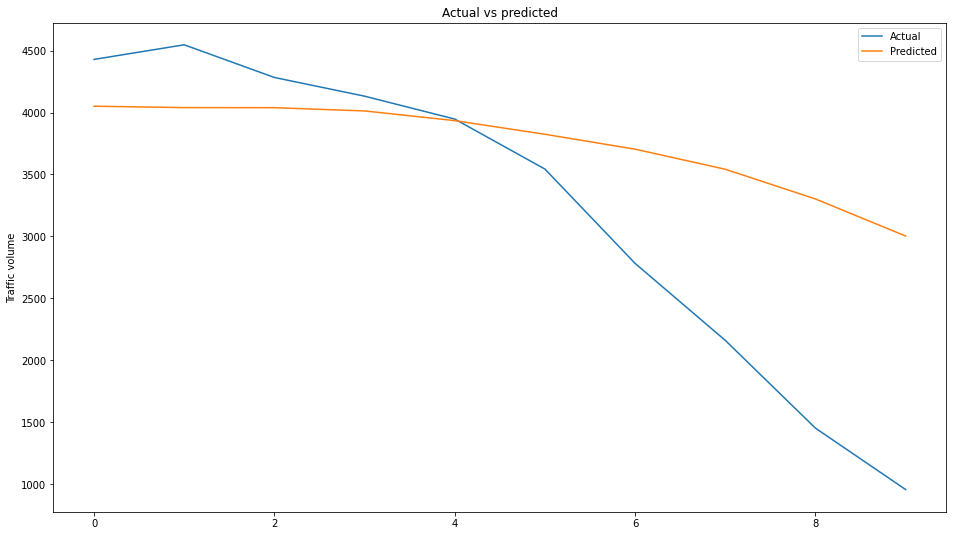

In [73]:
plt.plot(list(validate))
plt.plot(list(result_inv_trans))
plt.title('Actual vs predicted')
plt.ylabel('Traffic volume')
plt.legend(('Actual','Predicted'))
plt.show()